In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,0,1879,0,1,4,0,1,0
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,0,1879,0,1,1,0,1,0
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1,1879,0,1,1,0,0,3
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1,1879,0,1,0,0,1,2
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,0,1879,0,1,4,0,1,0


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,1879,0,1,4,0,1,0
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,1879,0,1,1,0,1,0
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1879,0,1,1,0,0,3
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1879,0,1,0,0,1,2
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,1879,0,1,4,0,1,0


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)


Mutual Information Scores:
              Feature  MI Score
16    dependents_flag  0.035703
1              gender  0.033166
14          age_group  0.011529
0     telecom_partner  0.009540
15  is_senior_citizen  0.008561
6      num_dependents  0.008429
12    recent_customer  0.006527
4                city  0.006486
13     loyal_customer  0.006054
17     salary_bracket  0.003644
9            sms_sent  0.002564
3               state  0.002061
2                 age  0.002009
11        tenure_days  0.000746
10          data_used  0.000361
8          calls_made  0.000000
7    estimated_salary  0.000000
5             pincode  0.000000


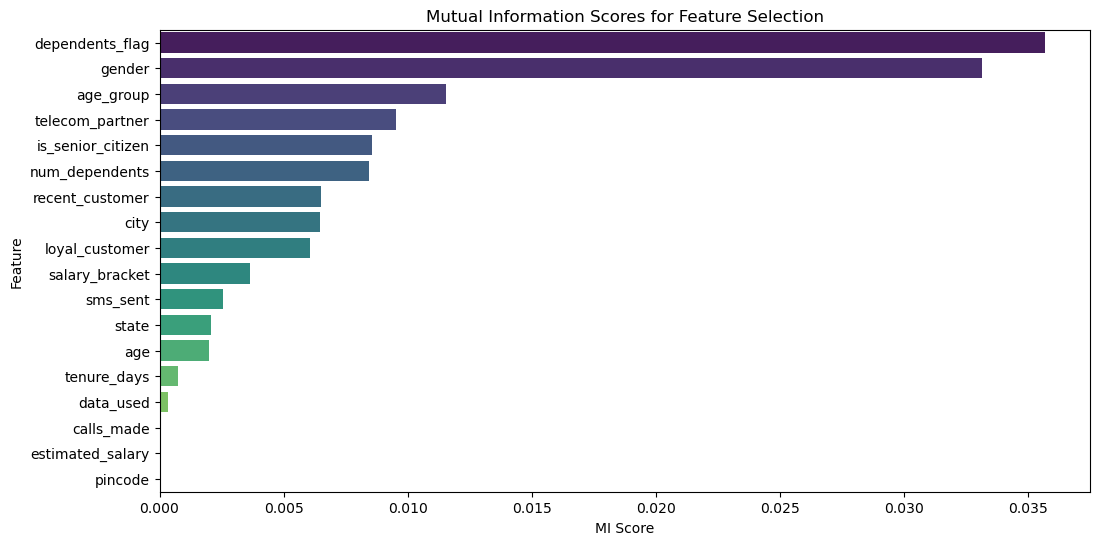

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select top N features 
top_features = mi_data.head(16)['Feature'].tolist()
X = X[top_features]

print("\nTop Selected Features:")
print(top_features)


Top Selected Features:
['dependents_flag', 'gender', 'age_group', 'telecom_partner', 'is_senior_citizen', 'num_dependents', 'recent_customer', 'city', 'loyal_customer', 'salary_bracket', 'sms_sent', 'state', 'age', 'tenure_days', 'data_used', 'calls_made']


In [7]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 157555, 0: 77561})


In [8]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train_resampled)

In [9]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [10]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (188092, 16)
X_test shape: (47024, 16)


In [11]:
#List to store models
models = []

In [12]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)    
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
   
    plt.figure(figsize=(12,6))
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()
    
   

Precision:  0.722247741540346
Recall:  0.8981340441736482
F1 Score:  0.800644997029619
ROC AUC Score:  0.7089760131818117


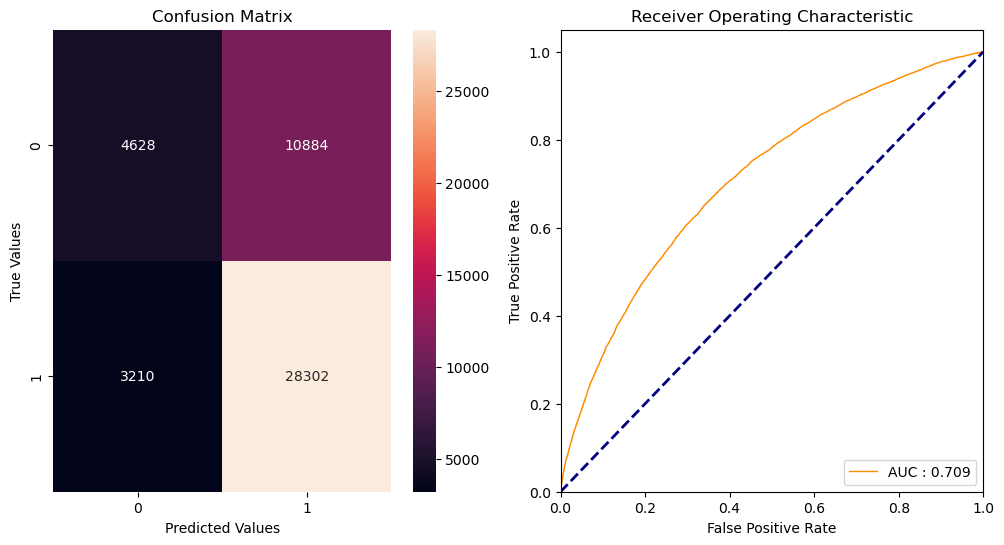

In [13]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.804591614229643
Recall:  0.8196560040619446
F1 Score:  0.8120539503882793
ROC AUC Score:  0.7076297039391725


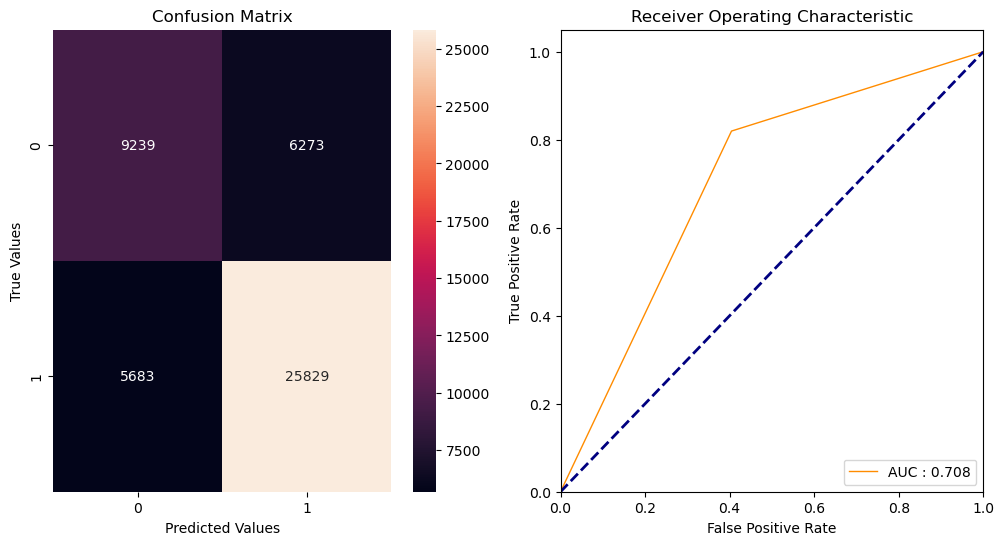

In [14]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.7633660784143267
Recall:  0.835967250571211
F1 Score:  0.7980188121961195
ROC AUC Score:  0.7448845874639831


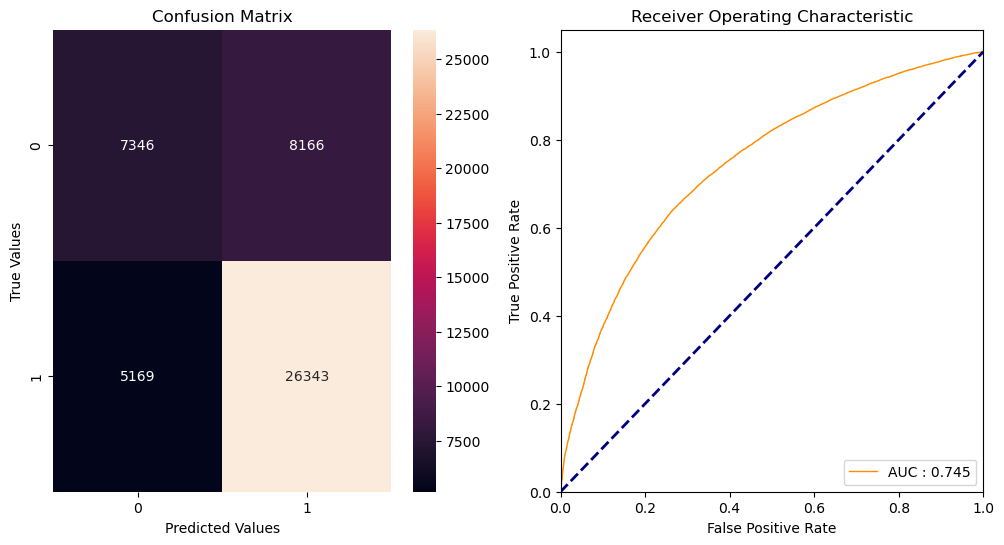

In [15]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.8461830371260515
Recall:  0.8491368367605991
F1 Score:  0.8476573637026008
ROC AUC Score:  0.8752064864555146


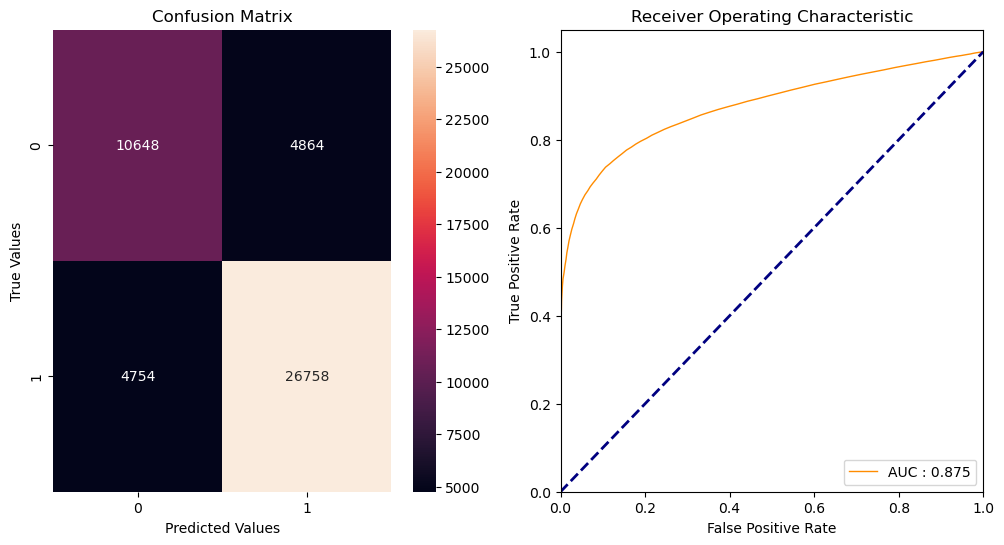

In [16]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.7881956250708376
Recall:  0.8827430820005078
F1 Score:  0.8327944434465002
ROC AUC Score:  0.852582768145105


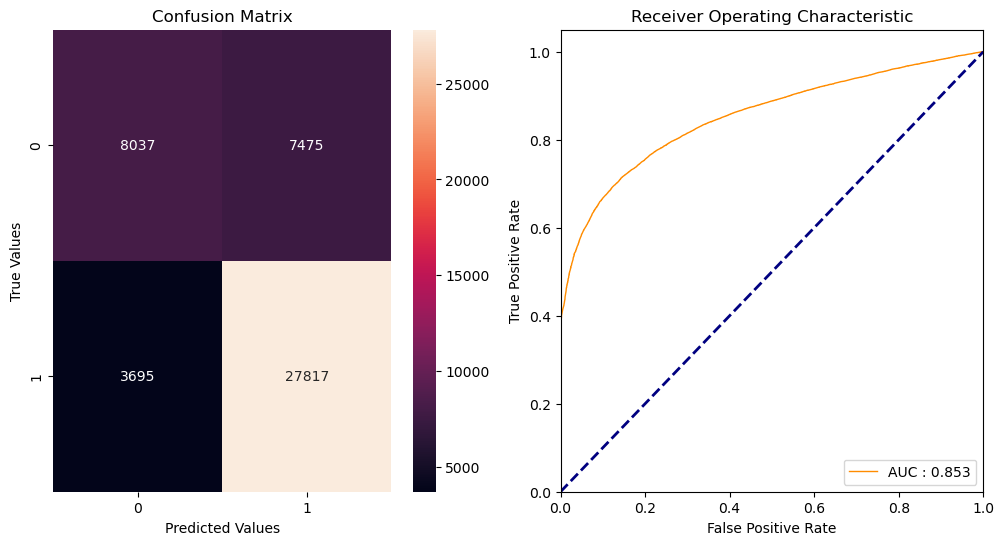

In [17]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.9038557125612441
Recall:  0.8078827113480579
F1 Score:  0.8531787258286136
ROC AUC Score:  0.8900634440316032


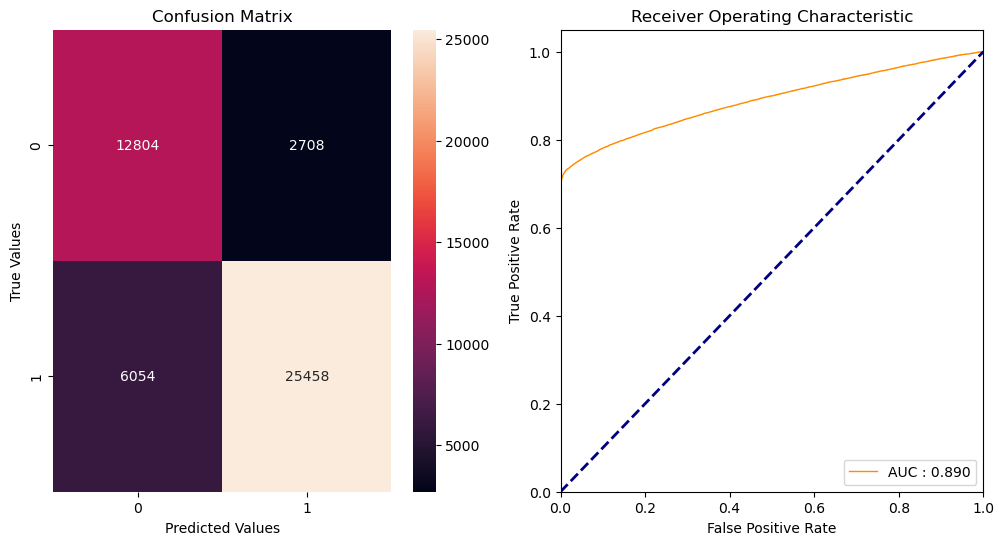

In [18]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [19]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
   

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2)
                                    
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall
5               XGBClassifier     88.93         80.80   81.69
3      RandomForestClassifier     86.36         75.15   84.47
4  GradientBoostingClassifier     84.97         69.56   88.40
2                  GaussianNB     74.12         65.20   83.52
0          LogisticRegression     70.60         59.73   89.93
1      DecisionTreeClassifier     69.01         69.01   80.56


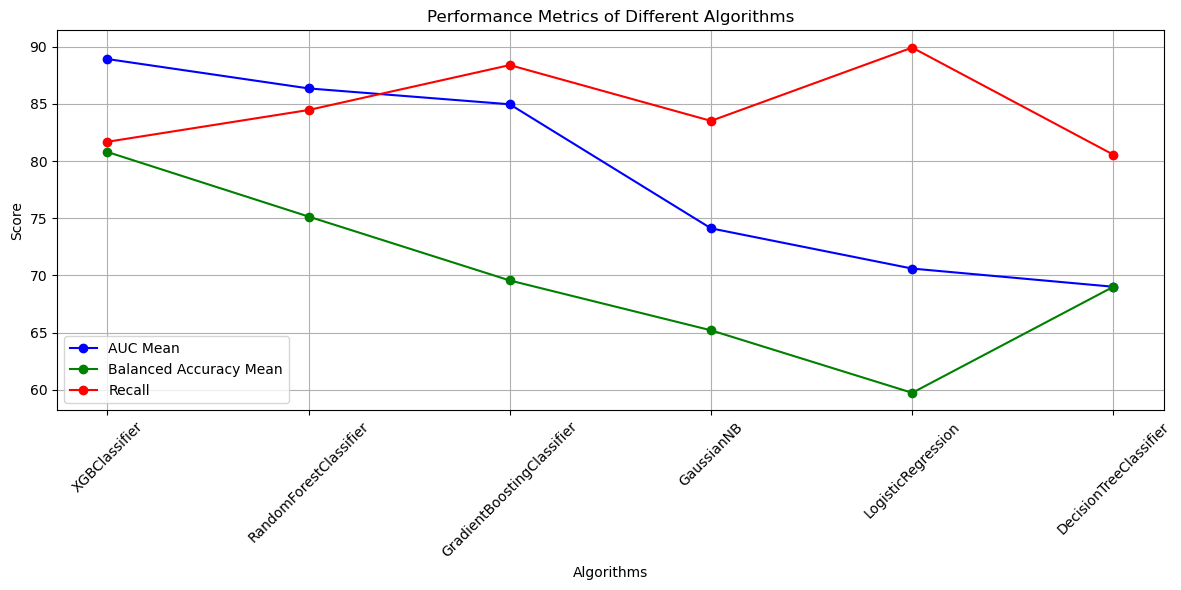

In [20]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.001, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    n_iter=10,
    scoring='roc_auc', 
    cv=skf, 
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 15, 'class_weight': 'balanced', 'ccp_alpha': 0.001}
Best Score for RF: 0.802901921617889


In [23]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.8688737831487077
Recall:  0.6571147499365321
F1 Score:  0.7483015322347498
ROC AUC Score:  0.8030222096028383


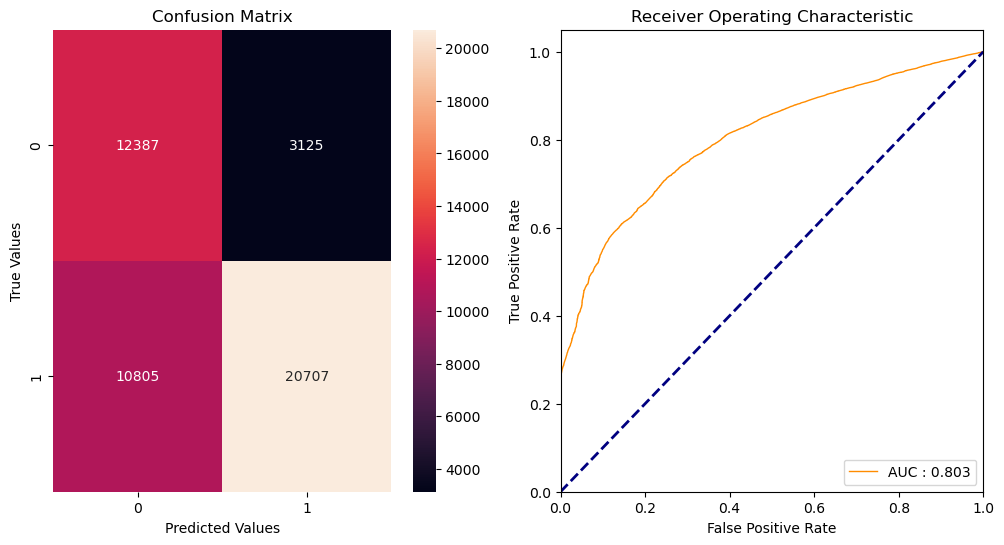

In [24]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

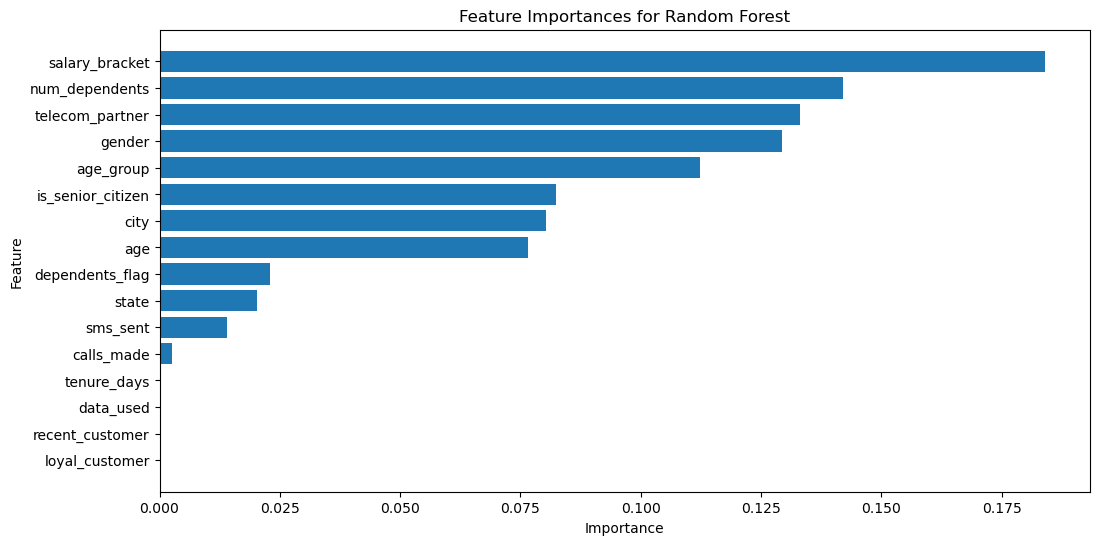

In [25]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [26]:
# Define hyperparameter search space

xgb_params_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3], 
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10],  
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), objective='binary:logistic', seed=42, n_jobs=-1, eval_metric="aucpr")


# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=10,  # Randomly search 10 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.9}
Best Score for XGBoost: 0.8909377841611349


In [34]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  gamma=best_params['gamma'],
                                  reg_alpha=best_params['reg_alpha'],
                                  reg_lambda=best_params['reg_lambda'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  seed=42,
                                  n_jobs=-1, 
                                  eval_metric="aucpr",
                                  early_stopping_rounds=10,
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=True
                     )

[0]	validation_0-aucpr:0.85607
[1]	validation_0-aucpr:0.87098
[2]	validation_0-aucpr:0.88318
[3]	validation_0-aucpr:0.88657
[4]	validation_0-aucpr:0.88745
[5]	validation_0-aucpr:0.89745
[6]	validation_0-aucpr:0.90684
[7]	validation_0-aucpr:0.90836
[8]	validation_0-aucpr:0.90971
[9]	validation_0-aucpr:0.91173
[10]	validation_0-aucpr:0.91339
[11]	validation_0-aucpr:0.91336
[12]	validation_0-aucpr:0.91404
[13]	validation_0-aucpr:0.91574
[14]	validation_0-aucpr:0.91607
[15]	validation_0-aucpr:0.91642
[16]	validation_0-aucpr:0.91753
[17]	validation_0-aucpr:0.91832
[18]	validation_0-aucpr:0.91904
[19]	validation_0-aucpr:0.91993
[20]	validation_0-aucpr:0.92029
[21]	validation_0-aucpr:0.92186
[22]	validation_0-aucpr:0.92304
[23]	validation_0-aucpr:0.92371
[24]	validation_0-aucpr:0.92378
[25]	validation_0-aucpr:0.92443
[26]	validation_0-aucpr:0.92470
[27]	validation_0-aucpr:0.92524
[28]	validation_0-aucpr:0.92650
[29]	validation_0-aucpr:0.92726
[30]	validation_0-aucpr:0.92735
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

In [ ]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [ ]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [ ]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))